<a href="https://colab.research.google.com/github/rrajasek95/nlp-243-notebooks/blob/main/Section_07_Sequence_Labeling_using_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# General utility
import os
from collections import Counter
from itertools import chain
import numpy as np
from tqdm.auto import tqdm

# Torch imports
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Gensim for loading word embeddings
import gensim
from gensim.test.utils import datapath


from sklearn.metrics import classification_report


# Plotting stuff
import seaborn as sns
import matplotlib.pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data download

In [ ]:
!wget https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/ark-tweet-nlp/twpos-data-v0.3.tgz

--2020-11-30 22:13:07--  https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/ark-tweet-nlp/twpos-data-v0.3.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433577 (423K) [application/octet-stream]
Saving to: ‘twpos-data-v0.3.tgz’

twpos-data-v0.3.tgz 100%[===================>] 423.42K  --.-KB/s    in 0.002s  

2020-11-30 22:13:07 (171 MB/s) - ‘twpos-data-v0.3.tgz’ saved [433577/433577]



In [ ]:
!tar xvzf twpos-data-v0.3.tgz

twpos-data-v0.3/
twpos-data-v0.3/anno_changes/
twpos-data-v0.3/daily547.conll
twpos-data-v0.3/full_data/
twpos-data-v0.3/oct27.conll
twpos-data-v0.3/oct27.splits/
twpos-data-v0.3/README.txt
twpos-data-v0.3/scripts/
twpos-data-v0.3/scripts/toconll.sh
twpos-data-v0.3/oct27.splits/oct27.dev
twpos-data-v0.3/oct27.splits/oct27.test
twpos-data-v0.3/oct27.splits/oct27.train
twpos-data-v0.3/oct27.splits/oct27.traindev
twpos-data-v0.3/oct27.splits/splits.txt
twpos-data-v0.3/full_data/daily547.supertsv
twpos-data-v0.3/full_data/oct27.supertsv
twpos-data-v0.3/anno_changes/oct27_reanno_changes_to_supertsv.diff


# Create raw data splits

In [ ]:
def load_split(data_path):
    with open(data_path, 'r') as data_file:
        examples = []
        
        tokens = []
        tags = []

        for line in data_file:
            stripped_line = line.rstrip()

            if len(stripped_line) == 0:
                # End of tag sequence for the example is indicated by empty line
                examples.append((tokens, tags))
                
                tokens = []
                tags = []
            else:
                # In the simple CoNLL format, (token, tag) is placed in each line as
                # <TOKEN>\t<TAG>\n
                token, tag = stripped_line.split("\t")

                tokens.append(token)
                tags.append(tag)
        
        return examples

In [ ]:
splits_path = os.path.join("twpos-data-v0.3", "oct27.splits")

train_path = os.path.join(splits_path, "oct27.train")
dev_path = os.path.join(splits_path, "oct27.dev")
test_path = os.path.join(splits_path, "oct27.test")

train_data = load_split(train_path)
dev_data = load_split(dev_path)
test_data = load_split(test_path)

In [ ]:
dev_data[0]

(['@ciaranyree',
  'it',
  'was',
  'on',
  'football',
  'wives',
  ',',
  'one',
  'of',
  'the',
  'players',
  'and',
  'his',
  'wife',
  'own',
  'smash',
  'burger'],
 ['@',
  'O',
  'V',
  'P',
  'N',
  'N',
  ',',
  '$',
  'P',
  'D',
  'N',
  '&',
  'D',
  'N',
  'V',
  '^',
  '^'])

## Load Twitter Word2Vec embeddings

In [ ]:
# You can download the embeddings from here: https://github.com/FredericGodin/TwitterEmbeddings

# Load embeddings into Gensim class containing matrix
weights_path = "/content/drive/MyDrive/NLP243/Sections/Section 07/word2vec_twitter_tokens.bin"
word2vec_weights = gensim.models.KeyedVectors.load_word2vec_format(datapath(weights_path), binary=True, unicode_errors='ignore', limit=1000000)

In [ ]:
# Test out the embeddings
print(word2vec_weights.most_similar('running'))

# print(word2vec_weights.most_similar('runnnnning'))

[('runnin', 0.7631831169128418), ('Running', 0.7020593881607056), ('runing', 0.6962482333183289), ('runnning', 0.6624175310134888), ('runnig', 0.6258898377418518), ('runnng', 0.5988162159919739), ('sprinting', 0.5925309062004089), ('run', 0.585367739200592), ('runnung', 0.5655999183654785), ('running/walking', 0.5529230237007141)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Feature Classes





In [ ]:
class W2VSequencer(object):
    def __init__(self, gensim_w2v):

        self.w2v = gensim_w2v
        self.w2v.add(['<s>'], [np.zeros((400,))])
        self.w2v.add(['</s>'], [np.zeros((400,))])
        self.w2v.add(['<pad>'], [np.zeros((400,))])
        self.w2v.add(['<unk>'], [np.zeros((400,))])

        self.bos_index = self.w2v.vocab.get('<s>')
        self.eos_index = self.w2v.vocab.get('</s>')
        self.unk_index = self.w2v.vocab.get('<unk>')
        self.pad_index = self.w2v.vocab.get('<pad>')

    def encode(self, tokens):
        # Input will look like:
        # [<s>, w1, w2, ..., wn, </s>]
        sequence = [self.bos_index.index]
        for token in tokens:

            index = self.w2v.vocab.get(token, self.unk_index).index
            sequence.append(index)
        sequence.append(self.eos_index.index)

        return sequence

    def create_padded_tensor_with_lengths(self, sequences):
        # Given a list of sequences, pad all to the same length

        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index.index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        
        return tensor, lengths

class Sequencer(object):
    def __init__(self, tokens, bos_token='<s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>'):
        self.word2idx = {}
        self.idx2word = {}

        self.pad_index = self.add_token(pad_token)
        self.unk_index = self.add_token(unk_token) 
        self.bos_index = self.add_token(bos_token)
        self.eos_index = self.add_token(eos_token)

        for token in tokens:
            self.add_token(token)

    def add_token(self, token):

        self.word2idx[token] = new_index = len(self.word2idx)
        self.idx2word[new_index] = token

        return new_index

    def encode(self, tokens):
        # Input will look like:
        # [<s>, w1, w2, ..., wn, </s>]

        sequence = [self.bos_index]
        for token in tokens:

            index = self.word2idx.get(token, self.unk_index)
            sequence.append(index)
        sequence.append(self.eos_index)

        return sequence

    def create_padded_tensor_with_lengths(self, sequences):
        # Input: [[4, 2, 3], [5, 4, 2, 4, 6]]
        # Output:
        # Tensor
        # 4 2 3 0 0
        # 5 4 2 4 6

        # Given a list of sequences, pad all to the same length
        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        
        return tensor, lengths

### Preparing the sequencers

In [ ]:
w2v_sequencer = W2VSequencer(word2vec_weights)
train_tags = list(set(chain.from_iterable([e[1] for e in train_data])))
label_sequencer = Sequencer(train_tags)


### Dataset Class

In [ ]:
class TaggerDataset(Dataset):
    def __init__(self, data, input_sequencer, label_sequencer):
        self.data = data
        # [(tokens, tags)]

        self.input_sequencer = input_sequencer # Convert word tokens to list of integers
        self.label_sequencer = label_sequencer # Convert tag tokens to list of integers

    def __getitem__(self, index):
        tokens, tags = self.data[index]

        x = self.input_sequencer.encode(tokens) # Input: [string], Output: [ints]
        y = self.label_sequencer.encode(tags) # Input: [string], Output: [ints]


        return x, y

    def __len__(self):
        return len(self.data)

### Make Dataset and DataLoader Objects

In [ ]:
train_dataset = TaggerDataset(train_data, w2v_sequencer, label_sequencer)
dev_dataset = TaggerDataset(dev_data, w2v_sequencer, label_sequencer)
test_dataset = TaggerDataset(test_data, w2v_sequencer, label_sequencer)

def prepare_batch(batch, in_sequencer, out_sequencer):
    # batch: [batch_len, (text, label)]
    texts, labels = zip(*batch)
    text_tensor, lengths = in_sequencer.create_padded_tensor_with_lengths(texts)
    label_tensor, _ = out_sequencer.create_padded_tensor_with_lengths(labels)
    return (text_tensor, lengths, label_tensor)

# Loader iterator: which produces a list of batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, collate_fn=lambda batch: prepare_batch(batch, w2v_sequencer, label_sequencer))
valid_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=4, collate_fn=lambda batch: prepare_batch(batch, w2v_sequencer, label_sequencer), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=lambda batch: prepare_batch(batch, w2v_sequencer, label_sequencer), shuffle=False)

## Model Classes

In [ ]:
class SimpleLSTMTagger(nn.Module):
    def __init__(self, output_size, pad_index, rnn_hidden_size=100, dropout_p=0.5, w2v_weights=None):
        super(SimpleLSTMTagger, self).__init__()

        self.pad_index = pad_index

        # Twitter embeddings of size 400
        self.embedding = nn.Embedding.from_pretrained(w2v_weights, freeze=False)
        embed_dim = 400

        # Single Layer LSTM, unidirectional
        self.rnn = nn.LSTM(
            input_size=embed_dim,
            hidden_size=rnn_hidden_size,
            bias=True
        )

        # Dropout layer applied after the embedding layers
        self.dropout = nn.Dropout(dropout_p)

        # Maps RNN hidden state to a vector of size num_labels
        self.fc = nn.Linear(rnn_hidden_size, output_size)
        

    def forward(self, x, lengths):
        # x size: [batch_size, seq_len]
        
        batch_size = x.size(0)
        embed = self.dropout(self.embedding(x)) 
        #embed: [batch_size = 4, seq_len, embed_dim = 400]


        packed_input = nn.utils.rnn.pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)
        # packed_input (PackedTensor)

        output, (h_n, c_n) = self.rnn(packed_input)

        seq_unpacked, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True, padding_value=self.pad_index)
        # output: [batch_size, seq_len, hidden_size]
        

        logits = self.fc(seq_unpacked)
        # logits: [batch_size, seq_len, output_size]

        return logits

## Model Setup

In [ ]:
hidden_size=50
output_size = len(label_sequencer.idx2word)

lstm_clf = SimpleLSTMTagger(output_size, label_sequencer.pad_index, rnn_hidden_size=hidden_size, w2v_weights=torch.FloatTensor(word2vec_weights.vectors))

In [ ]:
lstm_clf.to(device)

SimpleLSTMTagger(
  (embedding): Embedding(1000003, 400)
  (rnn): LSTM(400, 50)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=50, out_features=29, bias=True)
)

## Experiment Setup

In [ ]:
learning_rate = 1e-2
loss_function = nn.CrossEntropyLoss(ignore_index=label_sequencer.pad_index) # Avoid computing loss on padding tokens
optimizer = optim.Adam(lstm_clf.parameters(), lr=learning_rate)

## Train and Evaluation classes

In [ ]:
 def train(model, optimizer, loss_function, loader, device, log_every_n=10):
        """
        Run a single epoch of training
        """

        model.train() # Run model in training mode

        loss_history = []
        running_loss = 0.
        running_loss_history = []

        for i, batch in tqdm(enumerate(loader)):
            batch_size = batch[0].shape[0]
            optimizer.zero_grad() # Always set gradient to 0 before computing it

            logits = model(batch[0].to(device), batch[1]) # __call__ model() in this case: __call__ internally calls forward()
            # [batch_size, seq_len, num_classes]
            loss = loss_function(logits.view(-1, logits.size(2)), batch[2].view(-1).to(device)) # Compute loss: Cross entropy loss

            loss_history.append(loss.item())

            

            running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average

            loss.backward() # Perform backprop, which will compute dL/dw

            if log_every_n and i % log_every_n == 0:
                print("Running loss: ", running_loss)

            running_loss_history.append(running_loss)
            
            nn.utils.clip_grad_norm_(model.parameters(), 3.0) # We clip gradient's norm to 3

            optimizer.step() # Update step: w = w - eta * dL / dW : eta = 1e-2 (0.01), gradient = 5e30; update value of 5e28

        print("Epoch completed!")
        print("Epoch Loss: ", running_loss)
        print("Epoch Perplexity: ", math.exp(running_loss))

        # The history information can allow us to draw a loss plot
        return loss_history, running_loss_history

    
def evaluate(model, optimizer, loss_function, loader, device, labels, log_every_n=10):
    """
    Evaluate the model on a validation set
    """

    model.eval() # Run model in eval mode (disables dropout layer)

    batch_wise_true_labels = []
    batch_wise_predictions = []

    loss_history = []
    running_loss = 0.
    running_loss_history = []

    with torch.no_grad(): # Disable gradient computation - required only during training
        for i, batch in tqdm(enumerate(loader)):
            # batch[0] shape: (batch_size, input_size)

            logits = model(batch[0].to(device), batch[1]) # Run forward pass (except we don't store gradients)
            # logits shape: (batch_size, num_classes)
            
            loss = loss_function(logits.view(-1, logits.size(2)), batch[2].view(-1).to(device)) # Compute loss
            # No backprop is done during validation
            
            # Instead of using CrossEntropyLoss, you use BCEWithLogitsLoss
            # BCEWithLogitsLoss - independently calculates loss for each class
            

            loss_history.append(loss.item())

            running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average
            
            running_loss_history.append(running_loss)

            # logits : [batch_size, seq_len, num_classes] and each of the values in logits can be anything (-infinity, +infity)
            # Converts the raw outputs into probabilities for each class using softmax
            probs = F.softmax(logits, dim=-1) 
            # probs shape: (batch_size, seq_len, num_classes)
            # -1 dimension picks the last dimension in the shape of the tensor, in this case 'num_classes'
            

            # softmax vector: [[0.1, 0.2, 0.6, 0.1, 0.0], [0.9, 0.01, 0.01, 0.01, 0.07]]
            # output tensor: [2, 0]
            predictions = torch.argmax(probs, dim=-1) # Output predictions; Argmax picks the index with the highest probability among all the classes (choosing our most probable class)
            # predictions shape: (batch_size, seq_len)


            batch_wise_true_labels.append(batch[2].view(-1).tolist())
            batch_wise_predictions.append(predictions.view(-1).tolist())
    
    # flatten the list of predictions using itertools
    all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
    all_predictions = list(chain.from_iterable(batch_wise_predictions))

    # Non padding indices
    pad_index = labels.index('<pad>')

    
    non_padding_labels = [all_true_labels[i] for i in range(len(all_true_labels)) if all_true_labels[i] != pad_index]
    non_padding_predictions = [all_predictions[i] for i in range(len(all_true_labels)) if all_true_labels[i] != pad_index]

    print("Evaluation Loss: ", running_loss)
    # Now we can generate a classification report
    print("Classification report after epoch:")
    print(classification_report(non_padding_labels, non_padding_predictions, target_names=labels, labels=range(len(labels))))

    return loss_history, running_loss_history

In [ ]:
def run_training(model, optimizer, loss_function, train_loader, valid_loader, device, labels, n_epochs=10):
        # Useful for us to review what experiment we're running
        # Normally, you'd want to save this to a file
        print(model)
        print(optimizer)
        print(loss_function)

        train_losses = []
        train_running_losses = []

        valid_losses = []
        valid_running_losses = []

        for i in range(n_epochs):
            loss_history, running_loss_history = train(model, optimizer, loss_function, train_loader, device, log_every_n=10)
            valid_loss_history, valid_running_loss_history = evaluate(model, optimizer, loss_function, valid_loader, device, labels, log_every_n=10)

            train_losses.append(loss_history)
            train_running_losses.append(running_loss_history)

            valid_losses.append(valid_loss_history)
            valid_running_losses.append(valid_running_loss_history)

        # Training done, let's look at the loss curves
        all_train_losses = list(chain.from_iterable(train_losses))
        all_train_running_losses = list(chain.from_iterable(train_running_losses))

        all_valid_losses = list(chain.from_iterable(valid_losses))
        all_valid_running_losses = list(chain.from_iterable(valid_running_losses))

        train_epoch_idx = range(len(all_train_losses))
        valid_epoch_idx = range(len(all_valid_losses))
        # sns.lineplot(epoch_idx, all_losses)
        sns.lineplot(train_epoch_idx, all_train_running_losses)
        sns.lineplot(valid_epoch_idx, all_valid_running_losses)
        plt.show()

['<pad>', '<unk>', '<s>', '</s>', '#', 'G', '&', 'E', 'O', 'N', 'S', '$', '@', ',', 'V', 'R', 'X', 'U', '~', 'A', 'Y', 'M', '!', 'Z', 'D', 'T', 'L', 'P', '^']
SimpleLSTMTagger(
  (embedding): Embedding(1000003, 400)
  (rnn): LSTM(400, 50)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=50, out_features=29, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
CrossEntropyLoss()


Running loss:  3.3523263931274414
Running loss:  2.8384680314497515
Running loss:  2.425273276510693
Running loss:  2.0748917518123506
Running loss:  1.8088690173335196
Running loss:  1.6372912117079192
Running loss:  1.4798964955767648
Running loss:  1.374176279759743
Running loss:  1.2961795878263167
Running loss:  1.2193009172167095
Running loss:  1.1559076120357703
Running loss:  1.1156865326133936
Running loss:  1.0788387828621984
Running loss:  1.0455135616637368
Running loss:  1.0171708232122112
Running loss:  0.9845963160920619
Running loss:  0.9565656587759163
Running loss:  0.9425100030606256
Running loss:  0.9168541657002595
Running loss:  0.8941028684533705
Running loss:  0.8725031351123881
Running loss:  0.8579466775836542
Running loss:  0.8452396090079219
Running loss:  0.8286605993390603
Running loss:  0.816165684293415

Epoch completed!
Epoch Loss:  0.8078149027824405
Epoch Perplexity:  2.24300145176959



Evaluation Loss:  0.4718734311257921
Classification report after epoch:
              precision    recall  f1-score   support

       <pad>       0.00      0.00      0.00         0
       <unk>       0.00      0.00      0.00         0
         <s>       1.00      1.00      1.00       327
        </s>       1.00      1.00      1.00       327
           #       0.85      0.21      0.34        52
           G       0.60      0.28      0.38        65
           &       1.00      0.95      0.97        91
           E       0.81      0.67      0.74        52
           O       0.92      0.98      0.95       333
           N       0.81      0.87      0.84       660
           S       0.00      0.00      0.00         5
           $       0.44      0.50      0.47        86
           @       0.67      0.92      0.78       243
           ,       0.93      0.95      0.94       500
           V       0.93      0.91      0.92       751
           R       0.78      0.78      0.78       209
        

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running loss:  0.3743709921836853
Running loss:  0.45869607952508057
Running loss:  0.4469598084688186
Running loss:  0.44639371143233386
Running loss:  0.43188528280432625
Running loss:  0.42630396432736345
Running loss:  0.4055662858681601
Running loss:  0.397243791482818
Running loss:  0.39749386207557025
Running loss:  0.3933668258589703
Running loss:  0.38865443923980897
Running loss:  0.39212855757088283
Running loss:  0.38800011790734695
Running loss:  0.38713817508848586
Running loss:  0.3870998827595239
Running loss:  0.3805300059006705
Running loss:  0.37729790693391946
Running loss:  0.3796586733507485
Running loss:  0.37305625291407457
Running loss:  0.3688454157355882
Running loss:  0.36589752573204887
Running loss:  0.36533417992329165
Running loss:  0.36501033164189967
Running loss:  0.3630890017173766
Running loss:  0.36014776384743924

Epoch completed!
Epoch Loss:  0.359564833238721
Epoch Perplexity:  1.4327058129363506



Evaluation Loss:  0.5010519082226402
Classification report after epoch:
              precision    recall  f1-score   support

       <pad>       0.00      0.00      0.00         0
       <unk>       0.00      0.00      0.00         0
         <s>       1.00      1.00      1.00       327
        </s>       1.00      1.00      1.00       327
           #       0.81      0.40      0.54        52
           G       0.62      0.38      0.48        65
           &       1.00      0.96      0.98        91
           E       0.85      0.67      0.75        52
           O       0.94      0.96      0.95       333
           N       0.78      0.89      0.83       660
           S       0.00      0.00      0.00         5
           $       0.51      0.42      0.46        86
           @       0.61      0.97      0.75       243
           ,       0.93      0.95      0.94       500
           V       0.94      0.88      0.91       751
           R       0.77      0.79      0.78       209
        

Running loss:  0.27783480286598206
Running loss:  0.3138223060152747
Running loss:  0.3019478761014484
Running loss:  0.3003305336160045
Running loss:  0.2938266847191788
Running loss:  0.28975162845031893
Running loss:  0.2764220354986973
Running loss:  0.2737153069653982
Running loss:  0.2729126779753486
Running loss:  0.2754240425733421
Running loss:  0.27700231261182545
Running loss:  0.2814253998232318
Running loss:  0.27994698593931755
Running loss:  0.28218305770677465
Running loss:  0.2847294275853651
Running loss:  0.2816517593844837
Running loss:  0.28049394044076437
Running loss:  0.28310234356693365
Running loss:  0.27927315961672455
Running loss:  0.27659181850664905
Running loss:  0.2753372306365576
Running loss:  0.2767499935464554
Running loss:  0.27787796746754007
Running loss:  0.27831224785932224
Running loss:  0.2766639750095325

Epoch completed!
Epoch Loss:  0.276767204374075
Epoch Perplexity:  1.3188593106164626



Evaluation Loss:  0.5334269836908433
Classification report after epoch:
              precision    recall  f1-score   support

       <pad>       0.00      0.00      0.00         0
       <unk>       0.00      0.00      0.00         0
         <s>       1.00      1.00      1.00       327
        </s>       1.00      1.00      1.00       327
           #       0.74      0.48      0.58        52
           G       0.60      0.40      0.48        65
           &       1.00      0.93      0.97        91
           E       0.85      0.65      0.74        52
           O       0.91      0.95      0.93       333
           N       0.73      0.90      0.81       660
           S       1.00      0.20      0.33         5
           $       0.42      0.41      0.41        86
           @       0.76      0.90      0.82       243
           ,       0.90      0.95      0.93       500
           V       0.92      0.90      0.91       751
           R       0.81      0.80      0.80       209
        

Running loss:  0.23919524252414703
Running loss:  0.2655699937181039
Running loss:  0.2595832922628948
Running loss:  0.2580618307955804
Running loss:  0.24764329576637692
Running loss:  0.24132918055151026
Running loss:  0.23476829428653248
Running loss:  0.23165748646141776
Running loss:  0.2295034720022001
Running loss:  0.2327528579140102
Running loss:  0.2331954368786646
Running loss:  0.23761534392162478
Running loss:  0.23476722858045707
Running loss:  0.2348122974104098
Running loss:  0.23757014072216145
Running loss:  0.23460392355425466
Running loss:  0.2346173479042438
Running loss:  0.23631121786801434
Running loss:  0.23328979173417908
Running loss:  0.23086728202422874
Running loss:  0.23061060075143078
Running loss:  0.23092405061939306
Running loss:  0.23273386197729343
Running loss:  0.23355511180830718
Running loss:  0.23379471646119443

Epoch completed!
Epoch Loss:  0.23328327524662013
Epoch Perplexity:  1.2627391314067453



Evaluation Loss:  0.5464595596237884
Classification report after epoch:
              precision    recall  f1-score   support

       <pad>       0.00      0.00      0.00         0
       <unk>       0.00      0.00      0.00         0
         <s>       1.00      1.00      1.00       327
        </s>       1.00      1.00      1.00       327
           #       0.64      0.48      0.55        52
           G       0.52      0.35      0.42        65
           &       1.00      0.92      0.96        91
           E       0.77      0.71      0.74        52
           O       0.92      0.95      0.94       333
           N       0.78      0.87      0.83       660
           S       1.00      0.60      0.75         5
           $       0.45      0.51      0.48        86
           @       0.80      0.88      0.84       243
           ,       0.93      0.94      0.94       500
           V       0.93      0.89      0.91       751
           R       0.80      0.75      0.77       209
        

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


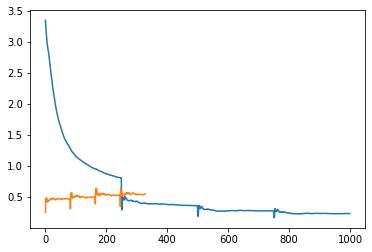

In [ ]:
label_list = [label_sequencer.idx2word[i] for i in range(len(label_sequencer.idx2word))]

print(label_list)
run_training(lstm_clf, optimizer, loss_function, train_loader, valid_loader, device, label_list, n_epochs=4)

In [ ]:
print("Evaluation on test set")
evaluate(lstm_clf, optimizer, loss_function, test_loader, device, label_list, log_every_n=10)

Evaluation on test set



Evaluation Loss:  0.5157939029932024
Classification report after epoch:
              precision    recall  f1-score   support

       <pad>       0.00      0.00      0.00         0
       <unk>       0.00      0.00      0.00         0
         <s>       1.00      1.00      1.00       500
        </s>       1.00      1.00      1.00       500
           #       0.67      0.44      0.53        78
           G       0.24      0.23      0.23        70
           &       0.99      0.98      0.99       127
           E       0.79      0.78      0.78        63
           O       0.93      0.94      0.93       505
           N       0.80      0.88      0.84       981
           S       0.75      0.50      0.60         6
           $       0.38      0.45      0.41        85
           @       0.79      0.87      0.83       330
           ,       0.95      0.95      0.95       880
           V       0.94      0.89      0.91      1053
           R       0.76      0.81      0.78       339
        

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


([0.7006891369819641,
  0.45925208926200867,
  0.31481999158859253,
  0.4070170223712921,
  0.29012858867645264,
  0.45144855976104736,
  0.5042242407798767,
  0.3511987626552582,
  0.4751989543437958,
  0.23687487840652466,
  0.6624816060066223,
  0.6872777342796326,
  0.47881096601486206,
  0.30139902234077454,
  0.17587785422801971,
  0.6536751389503479,
  0.615035355091095,
  1.0061370134353638,
  0.18497812747955322,
  0.22598868608474731,
  0.5676613450050354,
  0.7599863409996033,
  0.6863417625427246,
  0.23041629791259766,
  0.206008642911911,
  0.8092441558837891,
  0.3676867187023163,
  0.5644270181655884,
  0.65610271692276,
  0.8222359418869019,
  0.3331598937511444,
  0.8454391956329346,
  0.5425511598587036,
  0.6519476175308228,
  0.7522041201591492,
  0.635339617729187,
  0.40970155596733093,
  0.6522890329360962,
  0.34531134366989136,
  0.7003124952316284,
  0.9348519444465637,
  0.35227182507514954,
  0.5842916965484619,
  0.4468477964401245,
  0.5370994210243225,
 

# References
* Part-of-Speech Tagging from 97% to 100%:
Is It Time for Some Linguistics? https://nlp.stanford.edu/pubs/CICLing2011-manning-tagging.pdf
* Twitter Word Embeddings: https://fredericgodin.com/research/twitter-word-embeddings/